<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# A Tour of the Xarray Ecosystem

Xarray is easily extensible.
This means it is easy to add onto to build custom packages that tackle particular computational problems.

These packages can plug in to xarray in various different ways. They may build directly on top of xarray, or they may take advantage of some of xarray's dedicated interfacing features:
- Accessors
- Backend (filetype) entrypoint
- Duck-array wrapping interface
- Metadata attributes
- Flexible indexes (coming soon!)

Here we introduce two popular and widely used extensions that are installable as their own packages (via conda and pip). These packages integrate with xarray using one or more of the features mentioned above.

- [rioxarray](https://corteva.github.io/rioxarray/stable/index.html), for working with geospatial raster data using rasterio
- [pint-xarray](https://pint-xarray.readthedocs.io/en/latest/), for unit-aware computations using pint.

## (Preface) The accessor interface

Before we look at the packages we need to briefly introduce a feature they commonly use: ["xarray accessors"](https://docs.xarray.dev/en/stable/internals/extending-xarray.html).

An accessor is a way of attaching a custom function to xarray types so that it can be called as if it were a method, but while retaining a clear separation between "core" xarray API and custom API.

For example, imagine you're a statistician who regularly uses a special `skewness` function which acts on dataarrays but is only of interest to people in your specific field.

You can create a method which applies this skewness function to an xarray objects, and then register the method under a custom `stats` accessor like this

In [ ]:
from scipy.stats import skew

import xarray as xr


@xr.register_dataarray_accessor("stats")
class StatsAccessor:
    def __init__(self, da):
        self._da = da

    def skewness(self, dim):
        return self._da.reduce(func=skew, dim=dim)

Now we can conveniently access this functionality via the `stats` accessor

In [ ]:
import xarray as xr

ds = xr.tutorial.load_dataset("air_temperature")

In [ ]:
ds['air'].stats.skewness(dim="time")

Notice how the presence of `.stats` clearly differentiates our new "accessor method" from core xarray methods.

This accessor-style syntax is used heavily by the other libraries we are about to cover.

## hvplot via accessors

The [HoloViews library](https://holoviews.org/) makes great use of accessors to allow seamless plotting of xarray data using a completely different plotting backend.

We first need to import the code that registers the hvplot accessor

In [ ]:
import hvplot.xarray

And now we can call the `.hvplot` method to plot using holoviews in the same way that we would have used `.plot` to plot using matplotlib.

In [ ]:
ds['air'].isel(time=1).hvplot(cmap="fire")

For some more examples of how powerful holoviews is [see here](https://tutorial.xarray.dev/intermediate/hvplot.html).

## Rioxarray via the backend entrypoint
more details about rioxarray here

In [ ]:
import xarray as xr
import rioxarray  # this activates the rio accessor

In [ ]:
# rioxarray example

## cf-xarray via metadata attributes

Xarray objects can store [arbitrary metadata](https://docs.xarray.dev/en/stable/getting-started-guide/faq.html#what-is-your-approach-to-metadata) in the form of a `dict` attached to each `DataArray` and `Dataset` object, accessible via the `.attrs` property.

In [ ]:
xr.DataArray(name="Hitchhiker", data=0, attrs={"life": 42, "name": "Arthur Dent"})

Normally xarray operations ignore this metadata, simply carting it around until you explicitly choose to use it. However sometimes we might want to write custom code which makes use of the metadata.

[cf_xarray](https://cf-xarray.readthedocs.io/) is a project that tries to
let you make use of other [Climate and Forecast metadata convention attributes](http://cfconventions.org/) (or "CF attributes") that xarray ignores. It attaches itself
to all xarray objects under the `.cf` namespace.

Where xarray allows you to specify dimension names for analysis, `cf_xarray`
lets you specify logical names like `"latitude"` or `"longitude"` instead as
long as the appropriate CF attributes are set.

For example, the `"longitude"` dimension in different files might be labelled as: (lon, LON, long, x…), but cf_xarray let's you always refer to the logical name `"longitude"` in your code:

In [ ]:
import cf_xarray

In [ ]:
# describe cf attributes in dataset
ds.air.cf.describe()

The following `mean` operation will work with any dataset that has appropriate
attributes set that allow detection of the "latitude" variable (e.g.
`units: "degress_north"` or `standard_name: "latitude"`)


In [ ]:
# demonstrate equivalent of .mean("lat")
ds.air.cf.mean("latitude")

In [ ]:
# demonstrate indexing
ds.air.cf.sel(longitude=242.5, method="nearest")

## Pint via duck array wrapping

### Why use pint

[Pint](https://pint.readthedocs.io/en/stable/) defines physical units, allowing you to work with numpy-like arrays which track the units of your values through computations.

Pint defines a numpy-like array class called `pint.Quantity`, which is made up of a numpy array and a `pint.Unit` instance.

In [13]:
from pint import Unit
import numpy as np

# you can create a pint.Quantity by multiplying a value by a pint.Unit
d = np.array(10) * Unit("metres")
d

10 <Unit('meter')>

These units are automatically propagated through operations

In [14]:
t = 1 * Unit("seconds")
v = d / t
v

10.0 <Unit('meter / second')>

Or if the operation involves inconsistent units, a `pint.DimensionalityError` is raised.

In [15]:
d + t

DimensionalityError: Cannot convert from 'meter' ([length]) to 'second' ([time])

### pint inside xarray objects

We have already seen that xarray can wrap numpy arrays or dask arrays, but in fact xarray can wrap any type of array that behaves similarly to a numpy array.
Using this feature we can store a `pint.Quantity` array inside an xarray DataArray

In [16]:
da = xr.DataArray(d)
da

<xarray.DataArray ()>
<Quantity(10, 'meter')>

We can see that the data type stored within the DataArray is a `Quantity` object, rather than just a `np.ndarray` object, and the units of the data are displayed in the repr.

The reason this works is that a `pint.Quantity` array is what we call a "duck array", in that it behaves so similarly to a `numpy.ndarray` that xarray can treat them the same way. (See [python duck typing](https://towardsdatascience.com/duck-typing-python-7aeac97e11f8))

### pint-xarray

The convenience package [pint-xarray](https://pint-xarray.readthedocs.io/en/latest/index.html) makes it easier to get the benefits of pint whilst working with xarray objects.

It provides utility accessor methods for promoting xarray data to pint quantities (which we call "quantifying") in various ways and for manipulating the resulting objects.

In [17]:
# to be able to read unit attributes following the CF conventions
import cf_xarray.units  # must be imported before pint_xarray
import pint_xarray

xr.set_options(display_expand_data=False)

pint-xarray provides the `.pint` accessor, which firstly allows us to easily extract the units of our data

In [18]:
da.pint.units

<Unit('meter')>

The `.pint.quantify()` accessor gives us various ways to convert normal xarray data to be unit-aware.

Note: It is preferred to use `.pint.quantify()` to convert xarray data to use pint rather than explicitly creating a `pint.Quantity` array and placing it inside the xarray object, because pint-xarray will handle various subtleties involving dask etc.

We can explicitly specify the units we want

In [21]:
da = xr.DataArray([4.5, 6.7, 3.8], dims="time")
da.pint.quantify("V")

Magnitude,[4.5 6.7 3.8]
Units,volt


Or if the data has a "units" entry in its `.attrs` metadata dictionary, we can automatically use that to convert each variable.

For example, the xarray tutorial dataset we opened earlier has units in its attributes

In [22]:
ds.air.attrs['units']

'degK'

which we can automatically read with `.pint.quantify()`:

In [23]:
quantified_air = ds.pint.quantify()
quantified_air

<xarray.Dataset>
Dimensions:  (time: 2920, lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 [K] 241.2 242.5 243.5 ... 296.19 295.69
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Here we have actually gone even further, and used cf-xarray to automatically interpret cf-compliant units in the `.attrs` to valid pint units.
This automatically happened just as a result of importing cf-xarray above.

When we plot quantified data with xarray the correct units will automatically appear on the plot

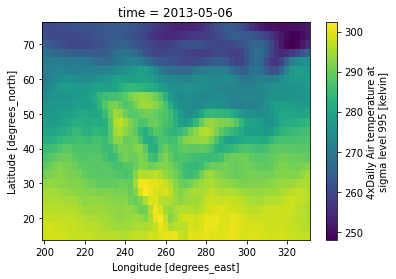

In [24]:
quantified_air["air"].isel(time=500).plot()

If we want to cast the pint arrays back to numpy arrays, we can use `.pint.dequantify()`, which will also write the current units back out to the `.attrs["units"]` field

In [25]:
quantified_air.pint.dequantify()

<xarray.Dataset>
Dimensions:  (time: 2920, lat: 25, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

**Exercise:** Write a function which will raise an error if supplied with data in the wrong units.

In [26]:
from pint import DimensionalityError


def special_science_function(distance):
    if distance.pint.units != "miles":
        raise DimensionalityError("this function will only give the correct answer if the input is in units of miles")

**Exercise:** Try this on some of your data!

After you have imported pint-xarray (and maybe cf-xarray) as above, start with something like

`ds = xr.open_dataset(my_data).pint.quantify()`

Take a look at the [pint-xarray documentation](https://pint-xarray.readthedocs.io/en/latest/) or the [pint documentation](https://pint.readthedocs.io/en/stable/) if you get stuck.

## The wider world...

There are many other libraries in the wider xarray ecosystem. For a list of a few packages we particularly like for geoscience work [see here](https://tutorial.xarray.dev/overview/xarray-in-45-min.html#other-cool-packages), and for a [more exhaustive list see here](https://docs.xarray.dev/en/stable/ecosystem.html).